# Introduction to Data Science 
# Lecture 21: Dimensionality Reduction
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

In this lecture, we'll discuss
* dimensionality reduction 
* Principal Component Analysis (PCA)
* using PCA for visualization 

Recommended Reading:
* G. James, D. Witten, T. Hastie, and R. Tibshirani, An Introduction to Statistical Learning, Ch. 10.2 [digital version available here](http://www-bcf.usc.edu/~gareth/ISL/)
* V. Powell, [Principal Component Analysis: Explained Visually](http://setosa.io/ev/principal-component-analysis/)
* B. Everitt and T. Hothorn, [An Introduction to Applied Multivariate Analysis with R](https://www.springer.com/us/book/9781441996497), Ch. 3

In [1]:
# imports and setup 

import numpy as np

import pandas as pd
pd.set_option('display.notebook_repr_html', False)

from sklearn.datasets import load_iris, load_digits
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import homogeneity_score, v_measure_score

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

import seaborn as sns

## Recap: Supervised vs. Unsupervised Learning

### Supervised Learning
**Data:** both the features, $x$, and a response, $y$, for each item in the dataset.

**Goal:** 'learn' how to predict the response from the features.

**Examples:**
* Regression
* Classification

### Unsupervised Learning 
**Data:** only the features, $x$, for each item in the dataset.

**Goal:** discover 'interesting' things about the dataset.

**Examples:**
* Clustering
* Dimensionality reduction, Principal Component Analysis (PCA)

## Dimensionality Reduction


In data science, [**dimensionality reduction**](https://en.wikipedia.org/wiki/Dimensionality_reduction) is the process of reducing the number of features in a dataset. 

There are two approaches to dimensionality reduction: **feature selection** and **feature extraction**.

In **feature selection**, one just picks a subset of the available features. We discussed feature selection some in previous lectures in the context of classification. 

In **feature extraction**, the data is transformed from a high-dimensional space to a lower dimensional space. The most common method is called **principal component analysis (PCA)**, where the transformation is taken to be linear, but many other methods exist. In this class, we'll focus on PCA. 

**Why dimensionality reduction?**
- Remove redundancies and simplifies the dataset making it easier to understand.
- It's easier to visualize low dimensional data.
- It reduces storage space for large datasets (because of less features).
- It reduces time for computationally intensive tasks (again, becasue of less features).
- Reducing dimensionality can help avoid overfitting in supervised learning tasks.

## Principal Component Analysis (PCA)

**Problem:** Many datasets have too many features to be able to explore or understand in a reasonable way. Its difficult to even make a reasonable plot for a high-dimensional dataset.

**Idea**: In [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis), we find a small number of new features, which are linear combinations of the old features, that 'explain' most of the variance in the data. The *principal component directions* are the directions in feature space in which the data is the most variable. 

Before we get into the mathematical description of Principal Component Analysis (PCA), we can gain a lot of intuition by taking a look at [this visual overview](http://setosa.io/ev/principal-component-analysis/) by Victor Powell.

**Mathematical description:** Let the $p$ features in our dataset be $x = (x_1, x_2, \ldots x_p)$. We define a new feature, the *first principal component score*, by 
$$
z_1 = \phi_{1,1} x_1 + \phi_{2,1} x_2 + \cdots + \phi_{p,1} x_p = \phi_1^t x 
$$
Here, the coefficients $\phi_{j,1}$ are the *loadings* of the $j$-th feature on the first principal component. The vector $\phi_1 = (\phi_{1,1}, \phi_{2,1},\cdots, \phi_{p,1})$ is called the *loadings vector* for the first principal component. 

We want to find the loadings so that $z_1$ has maximal sample variance. 

Let $X$ be the $n\times p$ matrix where $X_{i,j}$ is the $j$-th feature for item $i$ in the dataset. $X$ is just the collection of the data in a matrix. 

**Important:** Assume each of the variables has been normalized to have mean zero, *i.e.*, the columns of $X$ should have zero mean. 

A short calculation shows that the sample variance of $z_1$ is then given by 
$$
Var(z_1) = \frac{1}{n} \sum_{i=1}^n \left( \sum_{j=1}^p \phi_{j,1} X_{i,j} \right)^2. 
$$
The variance can be arbitrarily large if the $\phi_{j,1}$ are allowed to be arbitrarily large. We constrain the $\phi_{j,1}$ to satisfy $\sum_{j=1}^p \phi_{j,1}^2 = 1$. In vector notation, this can be written $\| \phi_1 \| = 1$.

Putting this together, the first principal component is defined by $z_1 = \phi_1^t x$ where $\phi_1$ is the solution to the optimization problem 
\begin{align*}
\max_{\phi_1} \quad & \textrm{Var}(z_1) \\
\text{subject to} \quad & \| \phi_1\|^2 = 1. 
\end{align*}
Using linear algebra, it can be shown that $\phi_1$ is exactly the eigenvector corresponding to the largest eigenvalue of the *covariance matrix*, $X^tX$. 

We similarly define the second principal direction to be the linear combination of the features, 
$z_2 = \phi_2^t x$ with the largest variance, subject to the additional constraint that $z_2$ be uncorrelated with $z_1$. This is equivalent to $\phi_1^t \phi_2 = 0$. This corresponds to taking $\phi_2$ to be the eigenvector corresponding to the second largest eigenvalue of $X^tX$. Higher principal directions are defined analogously. 

## PCA in practice
We can use the [```PCA``` function](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from the ```sklearn.decomposition``` library. 

### Example: the Iris dataset

The dataset contains 4 features (attributes) of 50 samples containing 3 different types of iris plants. 

**Features (attributes):**
1. sepal length (cm) 
+ sepal width (cm) 
+ petal length (cm) 
+ petal width (cm) 

**Classes:**
1. Iris Setosa 
+ Iris Versicolour 
+ Iris Virginica

In [2]:
# import dataset
iris = load_iris()
X = iris.data
y = iris.target

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

### Previous ideas for plotting the data:
1. just plot along first two dimensions and ignore other dimensions
+ plot in three dimensions (3d scatter plot) and ignore other dimensions
+ make a scatterplot matrix with all pairs of dimensions

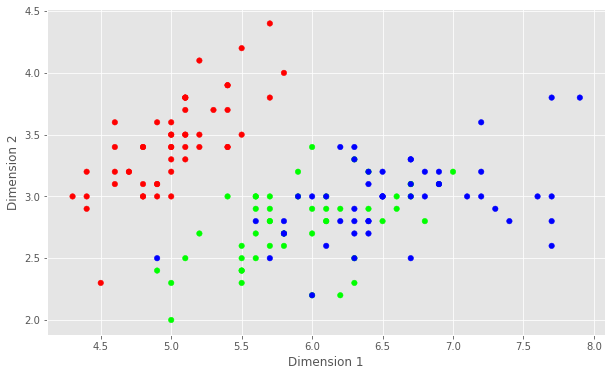

In [3]:
# plot along first two dimensions and ignore other diemtnsions

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,s=30)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

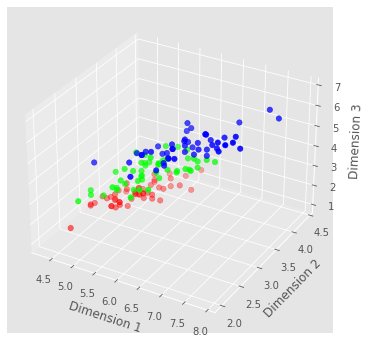

In [4]:
# 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1],zs= X[:, 2], c=y, cmap=cmap_bold,s=30)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.show()

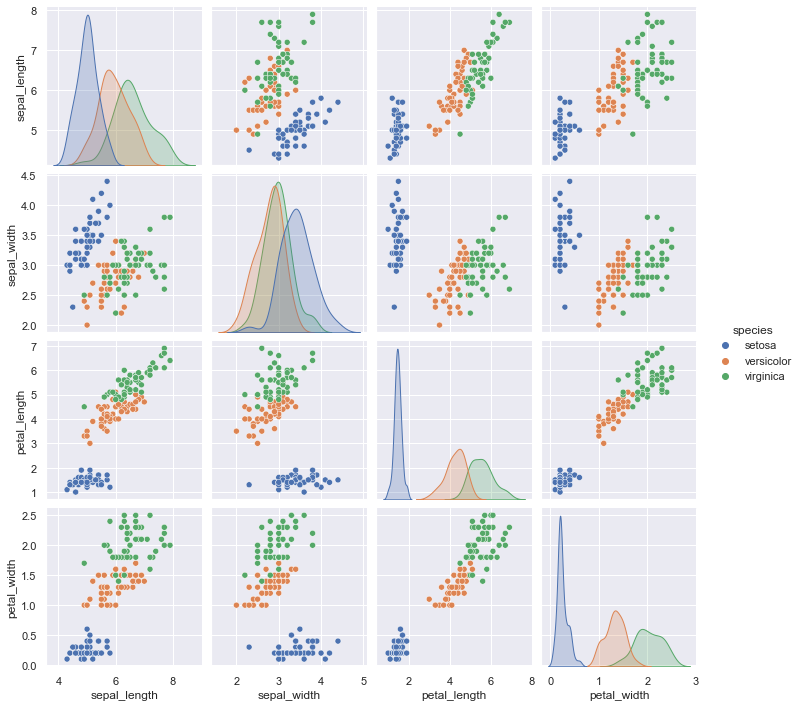

In [5]:
# scatterplot matrix
sns.set()
sns.pairplot(sns.load_dataset("iris"), hue="species");

### New idea: use PCA to plot the 2 most 'important' directions

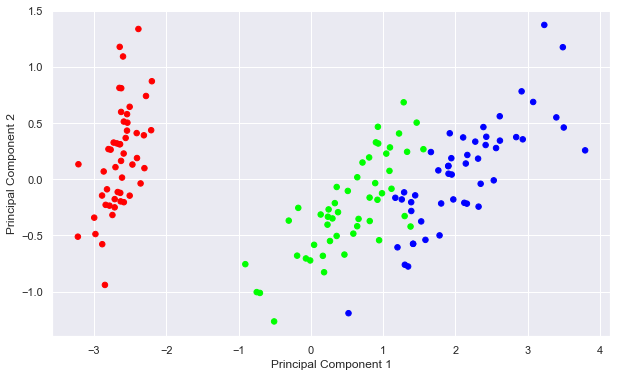

In [6]:
# PCA analysis 
pca_model = PCA()
X_PCA = pca_model.fit_transform(X)

plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y, cmap=cmap_bold,s=30)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### Example: use PCA to visualize cluster analysis of iris data
Principal components are very helpful for visualizing clusters.

v-measure score for clustering is 0.805693691215336


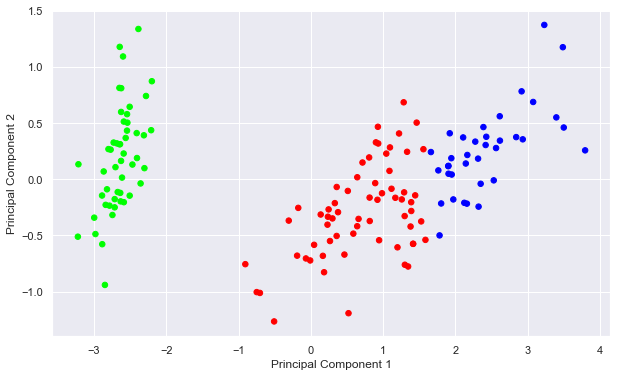

In [7]:
cluster_model = AgglomerativeClustering(linkage="average", affinity='euclidean', n_clusters=3)
y_pred = cluster_model.fit_predict(X)
h = v_measure_score(labels_true = y, labels_pred = y_pred)
print('v-measure score for clustering is ' + str(h))

# plot using PCA
plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y_pred, cmap=cmap_bold,s=30)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Compare this to the previous way we plotted using just the first two features

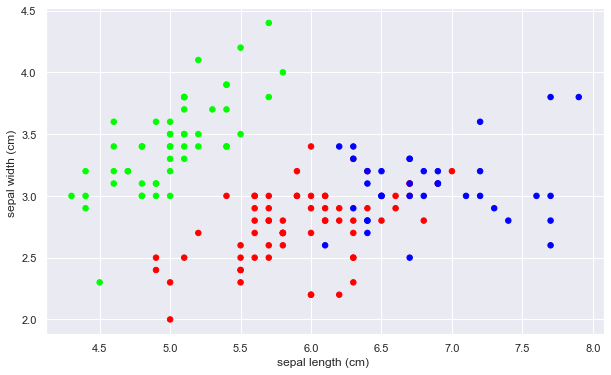

In [8]:
# plot using first two features
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap=cmap_bold,s=30)
plt.xlabel('sepal length (cm) ')
plt.ylabel('sepal width (cm) ')
plt.show()

## Number of principal components

For plotting the data, we generally just use the first 2 principal components. In other applications requiring dimensionality reduction, you might want to identify the number of principal components that can be used to explain the data. This can be done by considering the percentage of variance explained by each component or a *scree plot*. 

[0.92461872 0.05306648 0.01710261 0.00521218]


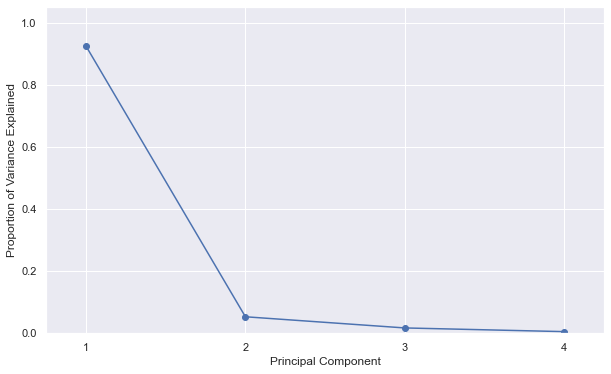

In [9]:
# Variance ratio of the four principal components
var_ratio = pca_model.explained_variance_ratio_
print(var_ratio)

plt.plot([1,2,3,4], var_ratio, '-o')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4])
plt.show()

## Example: visualizing clusters in the MNIST handwritten digit dataset

The MNIST handwritten digit dataset consists of images of handwritten digits, together with labels indicating which digit is in each image. 

Because both the features and the labels are present in this dataset (and labels for large datasets are generally difficult/expensive to obtain), this dataset is frequently used as a benchmark to compare various methods. 
For example, [this webpage](http://yann.lecun.com/exdb/mnist/) describes a variety of different classification results on MNIST (Note, the tests on this website are for a larger and higher resolution dataset than we'll use.) To see a comparison of classification methods implemented in scikit-learn on the MNIST dataset, see 
[this page](http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html).
The MNIST dataset is also a frequently used for benchmarking clustering algorithms and because it has labels, we can evaluate the homogeneity or purity of the clusters. 

There are several versions of the dataset. We'll use the one that is built-in to scikit-learn, described [here](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html). 

* Classes: 10  
* Samples per class: $\approx$180
* Samples total: 1797
* Feature Dimension: 64 (8 pixels by 8 pixels)
* Features: integers 0-16

Here are some examples of the images. Note that the digits have been size-normalized and centered in a fixed-size ($8\times8$ pixels) image.

<img src="http://scikit-learn.org/stable/_images/sphx_glr_plot_digits_classification_001.png" width="500">


<class 'numpy.ndarray'>
n_digits: 10, n_samples 1797, n_features 64


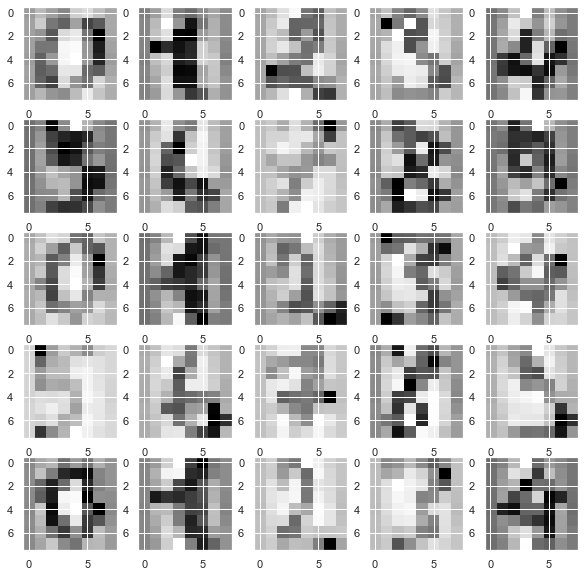

In [10]:
digits = load_digits()
X = scale(digits.data)
y = digits.target
print(type(X))

n_samples, n_features = X.shape
n_digits = len(np.unique(digits.target))
print("n_digits: %d, n_samples %d, n_features %d" % (n_digits, n_samples, n_features))

plt.figure(figsize= (10, 10))
for ii in np.arange(25):
    plt.subplot(5, 5, ii+1)
    plt.imshow(np.reshape(X[ii,:],(8,8)), cmap='Greys',interpolation='none')
plt.show()

Here we'll use PCA to visualize the results of a clustering of the MNIST dataset.

This example was taken from the [scikit-learn examples](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html).

0.46439389361905153


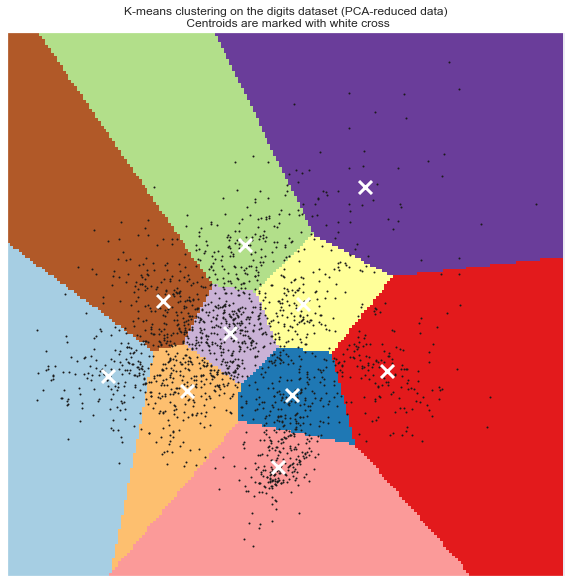

In [11]:
X_PCA = PCA(n_components=2).fit_transform(X)

kmeans_model = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans_model.fit(X_PCA)

print(metrics.v_measure_score(labels_true=y, labels_pred=kmeans_model.labels_))

# Plot the decision boundaries. For that, we will assign a color to each point in a mesh
x_min, x_max = X_PCA[:, 0].min() - 1, X_PCA[:, 0].max() + 1
y_min, y_max = X_PCA[:, 1].min() - 1, X_PCA[:, 1].max() + 1
h = .1     # step size of the mesh .02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh.
Z = kmeans_model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize= (10, 10))
plt.imshow(Z, interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(X_PCA[:, 0], X_PCA[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans_model.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


**Question:** What is the best number of dimensions to use for this clustering problem?

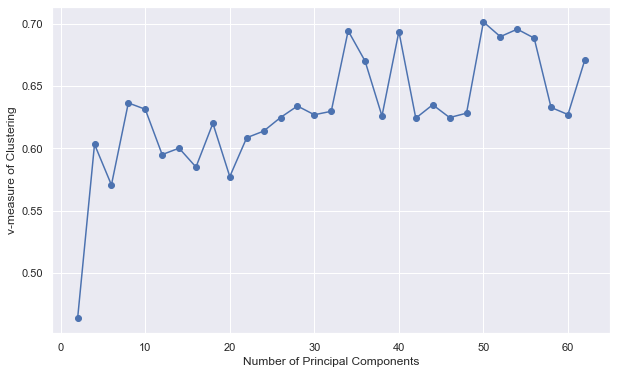

In [12]:
numPCs = np.arange(2,64,2)
vmeasure = []

for i, numPC in enumerate(numPCs):
    X_PCA = PCA(n_components=numPC).fit_transform(X)
    kmeans_model = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
    kmeans_model.fit(X_PCA)
    metric = metrics.v_measure_score(labels_true=y, labels_pred=kmeans_model.labels_)
    vmeasure.append(metric)
    
plt.plot(numPCs, vmeasure, '-o')
plt.xlabel('Number of Principal Components')
plt.ylabel('v-measure of Clustering')
plt.show()

It looks like the clustering performance improves until about 12 PC's. Increasing the dimension beyond this point is either detrimental or does not offer a big improvement with the kmeans algorithm.

## Example: 1988 Olympic heptathlon results

The [heptathlon](https://en.wikipedia.org/wiki/Heptathlon) is an Olympic event consisting of seven events: 
1. 100m hurdles
+ shot
+ high jump
+ 200m run
+ long jump
+ javelin
+ 800m run

The values for each of these events are then combined according to [official Olympic rules](https://en.wikipedia.org/wiki/Heptathlon#Points_system) to generate a *score* for each athlete. The athlete with the largest score wins. 

We'll use PCA to analyze the results for the women's heptathlon from the 1988 Olympics held in Seoul, Korea. 
The results for all 25 athletes are contained in the file `heptathlon.csv`. 

This example was taken from 'An Introduction to Applied Multivariate Analysis with R' by Brian Everitt and Torsten Hothorn, Ch. 3.10.2. 


In [13]:
hept = pd.read_csv("heptathlon.csv")
print(hept)

                    name     hurdles   highjump   shot   run200m   longjump  \
0   Joyner-Kersee (USA)        12.69       1.86  15.80     22.56       7.27   
1            John (GDR)        12.85       1.80  16.23     23.65       6.71   
2          Behmer (GDR)        13.20       1.83  14.20     23.10       6.68   
3    Sablovskaite (URS)        13.61       1.80  15.23     23.92       6.25   
4     Choubenkova (URS)        13.51       1.74  14.76     23.93       6.32   
5          Schulz (GDR)        13.75       1.83  13.50     24.65       6.33   
6         Fleming (AUS)        13.38       1.80  12.88     23.59       6.37   
7         Greiner (USA)        13.55       1.80  14.13     24.48       6.47   
8      Lajbnerova (CZE)        13.63       1.83  14.28     24.86       6.11   
9         Bouraga (URS)        13.25       1.77  12.62     23.59       6.28   
10        Wijnsma (HOL)        13.75       1.86  13.01     25.03       6.34   
11      Dimitrova (BUL)        13.24       1.80  12.

In [14]:
hept.describe()

         hurdles   highjump       shot    run200m   longjump    javelin  \
count  25.000000  25.000000  25.000000  25.000000  25.000000  25.000000   
mean   13.840000   1.782000  13.117600  24.649200   6.152400  41.482400   
std     0.736648   0.077942   1.491884   0.969557   0.474212   3.545656   
min    12.690000   1.500000  10.000000  22.560000   4.880000  35.680000   
25%    13.470000   1.770000  12.320000  23.920000   6.050000  39.060000   
50%    13.750000   1.800000  12.880000  24.830000   6.250000  40.280000   
75%    14.070000   1.830000  14.200000  25.230000   6.370000  44.540000   
max    16.420000   1.860000  16.230000  26.610000   7.270000  47.500000   

          run800m       score   
count   25.000000    25.000000  
mean   136.054000  6090.600000  
std      8.291088   568.469729  
min    124.200000  4566.000000  
25%    132.240000  5746.000000  
50%    134.740000  6137.000000  
75%    138.480000  6351.000000  
max    163.430000  7291.000000  

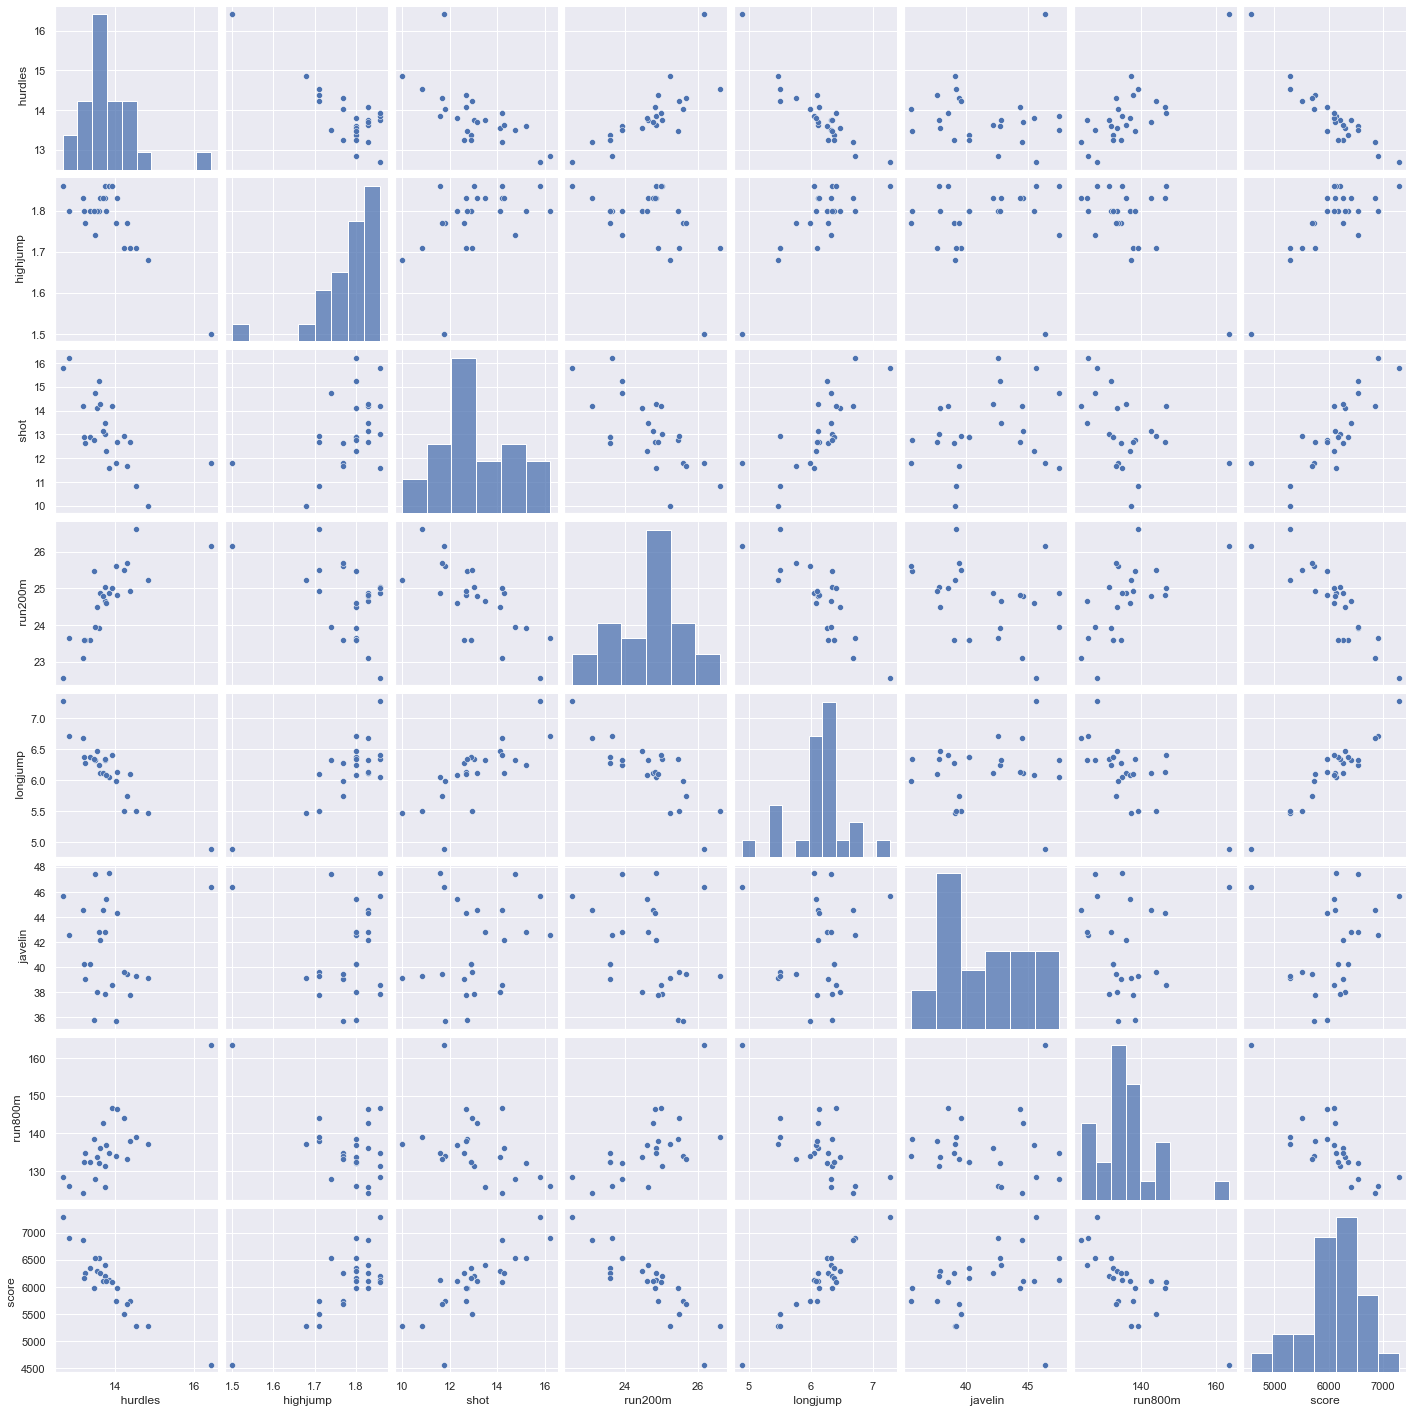

In [15]:
sns.set()
sns.pairplot(hept);

**Question:** Why in the matrix scatterplot are some of the results negatively correlated? 

These plots reveal that there is an outlier, namely, Launa (PNG). We'll remove this athlete before continuing. 

In [16]:
# remove outlier
hept = hept.drop(24)

Now, we'll do a principal component analysis on this data

In [17]:
# scale the dataset (important preprocessing step if features have different units!)
X = scale(hept.drop(['name ',' score '],axis=1).values)
#X = hept.drop(['name ',' score '],axis=1).values

# find PCA and transform to new coordinates
pca_model = PCA()
X_PCA = pca_model.fit_transform(X)

# create a new pandas dataframe 
df_plot = pd.DataFrame(X_PCA, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])
df_plot.head()

        PC1       PC2       PC3       PC4       PC5       PC6       PC7
0  4.859854  0.142870  0.006170  0.299727  0.369615  0.276321 -0.486110
1  3.215649 -0.968992  0.249166  0.560983 -0.769854 -0.385824 -0.052840
2  2.989121 -0.710298 -0.635678 -0.566676  0.194444  0.263348  0.112927
3  1.315841 -0.182857 -0.256023  0.650878 -0.616604  0.220398  0.542167
4  1.535787 -0.982459 -1.818885  0.800898 -0.602383 -0.081867 -0.307288

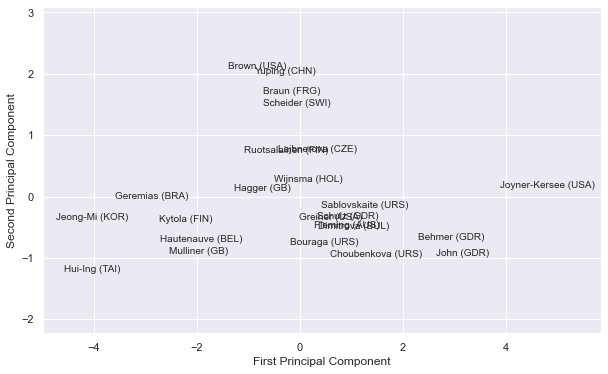

In [18]:
fig,ax1 = plt.subplots()

ax1.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax1.set_ylim(X_PCA[:,1].min()-1,X_PCA[:,1].max()+1)

# Plot Principal Components 1 and 2
for i,name in enumerate(hept['name '].values):
    ax1.annotate(name, (X_PCA[i,0], X_PCA[i,1]), ha='center',fontsize=10)

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
plt.show()

[0.61766317 0.12842778 0.11853453 0.06667967 0.04261745 0.01626797
 0.00980943]


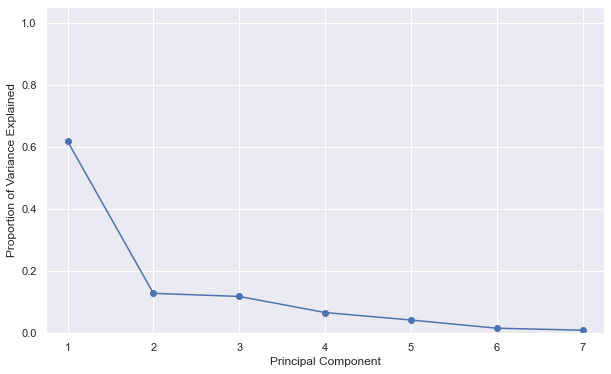

In [19]:
# Variance ratio of the four principal components
var_ratio = pca_model.explained_variance_ratio_
print(var_ratio)

plt.plot([1,2,3,4,5,6,7], var_ratio, '-o')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,7.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4,5,6,7])
plt.show()

Most of the variance in the athletes is contained in the first principle component. 

Let's make a plot of the first principle component vs. the score. 

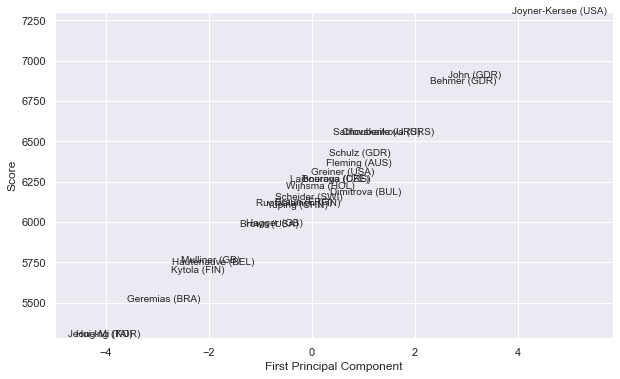

[[1.         0.99311684]
 [0.99311684 1.        ]]


In [20]:
fig,ax1 = plt.subplots()

ax1.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax1.set_ylim(hept[' score '].min()-10,hept[' score '].max()+10)

          
# Plot Principal Components 1 and score
for i,name in enumerate(hept['name '].values):
    ax1.annotate(name, (X_PCA[i,0], hept[' score '][i]), ha='center',fontsize=10)   

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Score')
plt.show()

# Compute correlation coefficient (PC1 and score)
print(np.corrcoef(X_PCA[:,0], hept[' score '].values))

The first principal component is highly correlated with the score determined by Olympic rules. Note that the winner of the heptathlon, [Jackie Joyner-Kersee](https://en.wikipedia.org/wiki/Jackie_Joyner-Kersee) really stands out. 

Read more about the 1988 Summer Olympics Women's heptathlon [here](https://en.wikipedia.org/wiki/Athletics_at_the_1988_Summer_Olympics_%E2%80%93_Women%27s_heptathlon). 

**Question:** How would the results have changed if we hadn't scaled the data before PCA?
